# Notebook for creating the visualization for the slides

### Comparing with ER and BA graph

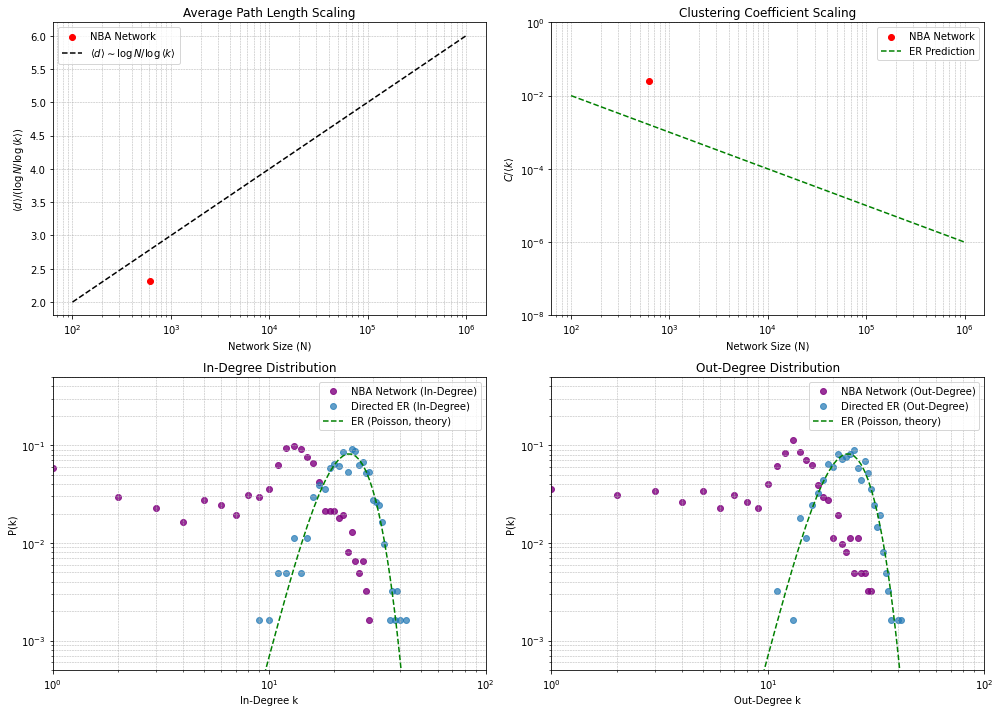

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import poisson
import seaborn as sns


# ----------------------------------
# 1) Load and Filter Your NBA Data
# ----------------------------------
file_path = "data/nba_player_interactions_2001_2025.csv"
original_df = pd.read_csv(file_path)

nba_team_ids = [
    1610612737, 1610612738, 1610612751, 1610612766, 1610612741, 1610612739,
    1610612742, 1610612743, 1610612765, 1610612744, 1610612745, 1610612754,
    1610612746, 1610612747, 1610612763, 1610612748, 1610612749, 1610612750,
    1610612740, 1610612752, 1610612760, 1610612753, 1610612755, 1610612756,
    1610612757, 1610612758, 1610612759, 1610612761, 1610612762, 1610612764
]
original_df = original_df[original_df['PLAYER1_TEAM_ID'].isin(nba_team_ids)]
df = original_df[(original_df['Season'] == 2023) & (original_df['EVENTMSGTYPE'] == 1)]

# ----------------------------------
# 2) Build the NBA Directed Graph
# ----------------------------------
G = nx.DiGraph()
for _, row in df.iterrows():
    passer = row["PLAYER2_ID"]
    scorer = row["PLAYER1_ID"]
    if passer == 0 or scorer == 0:
        continue
    if G.has_edge(passer, scorer):
        G[passer][scorer]["weight"] += 1
    else:
        G.add_edge(passer, scorer, weight=1)

N = G.number_of_nodes()
avg_degree = np.mean([deg for _, deg in G.degree()])

# ----------------------------------
# 3) Network-Level Metrics
# ----------------------------------
# (a) Average Path Length Scaling
if nx.is_strongly_connected(G):
    avg_path_length = nx.average_shortest_path_length(G)
else:
    largest_component = max(nx.strongly_connected_components(G), key=len)
    subgraph = G.subgraph(largest_component)
    avg_path_length = nx.average_shortest_path_length(subgraph)

scaled_path_length = avg_path_length / (np.log(N) / np.log(avg_degree))

# (b) Clustering Coefficient (global) scaled by <k>
C = nx.transitivity(G)      # or nx.average_clustering(G) for a different definition
C_scaled = C / avg_degree

# ----------------------------------
# 4) Degree Distributions (In & Out)
# ----------------------------------
# NBA in-degree distribution
in_degrees_nba = np.array([deg for _, deg in G.in_degree()])
unique_in_nba, counts_in_nba = np.unique(in_degrees_nba, return_counts=True)
P_k_in_nba = counts_in_nba / counts_in_nba.sum()

# NBA out-degree distribution
out_degrees_nba = np.array([deg for _, deg in G.out_degree()])
unique_out_nba, counts_out_nba = np.unique(out_degrees_nba, return_counts=True)
P_k_out_nba = counts_out_nba / counts_out_nba.sum()

# ----------------------------------
# 5) Generate Directed ER & BA Graphs for Comparison
# ----------------------------------
# (a) Directed ER Graph
p_er = avg_degree / (N - 1)
G_er_dir = nx.erdos_renyi_graph(N, p_er, directed=True)

# In-degree distribution (ER)
in_degrees_er = np.array([deg for _, deg in G_er_dir.in_degree()])
unique_in_er, counts_in_er = np.unique(in_degrees_er, return_counts=True)
P_k_in_er = counts_in_er / counts_in_er.sum()

# Out-degree distribution (ER)
out_degrees_er = np.array([deg for _, deg in G_er_dir.out_degree()])
unique_out_er, counts_out_er = np.unique(out_degrees_er, return_counts=True)
P_k_out_er = counts_out_er / counts_out_er.sum()

# (b) Directed Scale-Free (BA-like) Graph
# scale_free_graph returns a MultiDiGraph with directed preferential attachment
G_ba_dir = nx.scale_free_graph(N, alpha=0.41, beta=0.54, gamma=0.05)
# Convert to a simple DiGraph (no parallel edges/self-loops)
G_ba_dir = nx.DiGraph(G_ba_dir)

# In-degree distribution (BA)
in_degrees_ba = np.array([deg for _, deg in G_ba_dir.in_degree()])
unique_in_ba, counts_in_ba = np.unique(in_degrees_ba, return_counts=True)
P_k_in_ba = counts_in_ba / counts_in_ba.sum()

# Out-degree distribution (BA)
out_degrees_ba = np.array([deg for _, deg in G_ba_dir.out_degree()])
unique_out_ba, counts_out_ba = np.unique(out_degrees_ba, return_counts=True)
P_k_out_ba = counts_out_ba / counts_out_ba.sum()

# ----------------------------------
# 6) Theoretical Poisson & Power-Law (Optional)
# ----------------------------------
# Example: in-degree theoretical curves
k_range = np.arange(1, 3*int(avg_degree) + 1)

# Poisson with lambda = avg_degree
from scipy.stats import poisson
lambda_er = avg_degree
P_k_er_theory = poisson.pmf(k_range, mu=lambda_er)
P_k_er_theory /= P_k_er_theory.sum()  # normalize

# Power Law ~ k^-3
P_k_ba = (1.0 / (k_range ** 3))
P_k_ba /= P_k_ba.sum()  # normalize to 1

# ----------------------------------
# 7) Make a 2x2 Figure
# ----------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# -------------------------
# (1) Top-left: Avg Path Length
# -------------------------
axes[0, 0].scatter(N, scaled_path_length, color='red', label="NBA Network", zorder=3)
N_range = np.logspace(2, 6, 100)
axes[0, 0].plot(N_range, np.log(N_range) / np.log(10), 'k--',
                label=r"$\langle d \rangle \sim \log N / \log \langle k \rangle$")
axes[0, 0].set_xscale("log")
axes[0, 0].set_xlabel("Network Size (N)")
axes[0, 0].set_ylabel(r"$\langle d \rangle / (\log N / \log \langle k \rangle)$")
axes[0, 0].set_title("Average Path Length Scaling")
axes[0, 0].legend()
axes[0, 0].grid(True, which="both", linestyle="--", linewidth=0.5)

# -------------------------
# (2) Top-right: Clustering Coefficient
# -------------------------
axes[0, 1].scatter(N, C_scaled, color='red', label="NBA Network", zorder=3)
axes[0, 1].plot(N_range, 1/N_range, 'g--', label="ER Prediction")
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].set_ylim(1e-8, 1)
axes[0, 1].set_xlabel("Network Size (N)")
axes[0, 1].set_ylabel(r"$C / \langle k \rangle$")
axes[0, 1].set_title("Clustering Coefficient Scaling")
axes[0, 1].legend()
axes[0, 1].grid(True, which="both", linestyle="--", linewidth=0.5)

# -------------------------
# (3) Bottom-left: In-Degree Distribution
# -------------------------
axes[1, 0].scatter(unique_in_nba, P_k_in_nba, color='purple', alpha=0.8,
                   label="NBA Network (In-Degree)")
axes[1, 0].scatter(unique_in_er, P_k_in_er, marker='o', alpha=0.7,
                   label="Directed ER (In-Degree)")
# axes[1, 0].scatter(unique_in_ba, P_k_in_ba, marker='o', alpha=0.7,
#                    label="Directed BA (In-Degree)")

# Optional: Theoretical lines for in-degree
axes[1, 0].plot(k_range, P_k_er_theory, 'g--', label="ER (Poisson, theory)")
# axes[1, 0].plot(k_range, P_k_ba, 'b--', label=r"BA ($k^{-3}$) theory")

axes[1, 0].set_xscale("log")
axes[1, 0].set_yscale("log")
axes[1, 0].set_xlabel("In-Degree k")
axes[1, 0].set_ylabel("P(k)")
axes[1, 0].set_title("In-Degree Distribution")
axes[1, 0].legend()
axes[1, 0].grid(True, which="both", linestyle="--", linewidth=0.5)
axes[1, 0].set_xlim(1, 100)
axes[1, 0].set_ylim(5e-4, 0.5)

# -------------------------
# (4) Bottom-right: Out-Degree Distribution
# -------------------------
axes[1, 1].scatter(unique_out_nba, P_k_out_nba, color='purple', alpha=0.8,
                   label="NBA Network (Out-Degree)")
axes[1, 1].scatter(unique_out_er, P_k_out_er, marker='o', alpha=0.7,
                   label="Directed ER (Out-Degree)")
# axes[1, 1].scatter(unique_out_ba, P_k_out_ba, marker='o', alpha=0.7,
#                    label="Directed BA (Out-Degree)")

# (Optional) If you want theoretical lines for out-degree:
# It's trickier for scale-free out-degree, but for ER, out-degree ~ in-degree ~ Poisson
axes[1, 1].plot(k_range, P_k_er_theory, 'g--', label="ER (Poisson, theory)")

axes[1, 1].set_xscale("log")
axes[1, 1].set_yscale("log")
axes[1, 1].set_xlabel("Out-Degree k")
axes[1, 1].set_ylabel("P(k)")
axes[1, 1].set_title("Out-Degree Distribution")
axes[1, 1].legend()
axes[1, 1].grid(True, which="both", linestyle="--", linewidth=0.5)
axes[1, 1].set_xlim(1, 100)
axes[1, 1].set_ylim(5e-4, 0.5)

plt.tight_layout()
plt.show()


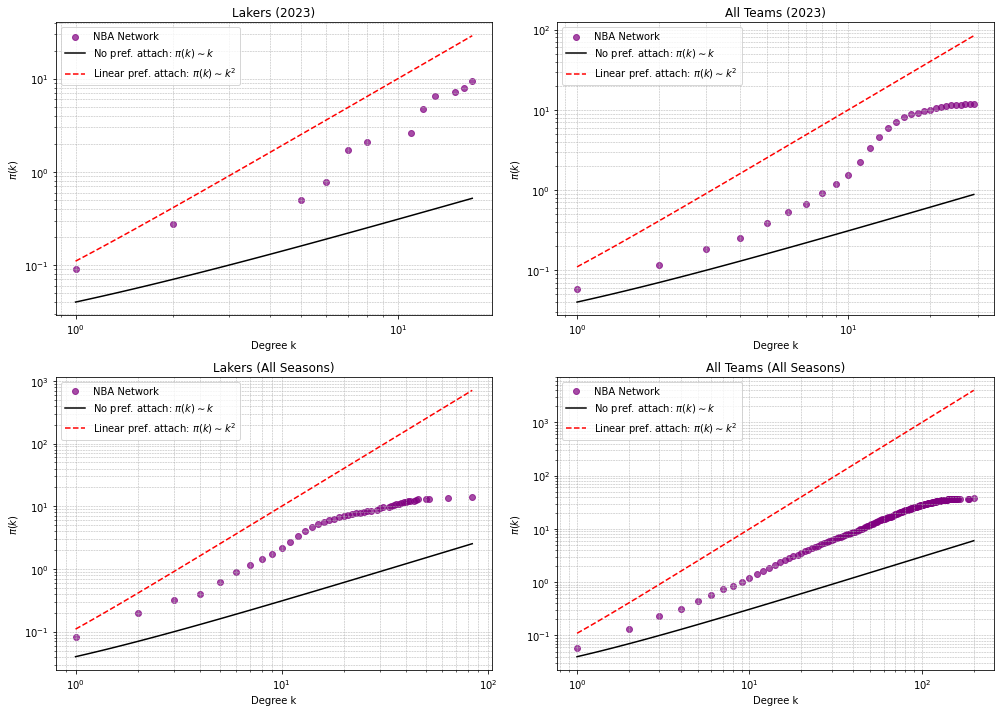

In [2]:
# Compute Preferential Attachment Function Π(k)
def compute_preferential_attachment(G):
    degrees = np.array(list(dict(G.in_degree()).values()))
    unique_k, counts = np.unique(degrees, return_counts=True)

    # Compute probability of new edges attaching to degree-k nodes
    Pk = counts / counts.sum()  # Normalize frequency of each degree
    Pi_k = unique_k * Pk  # Preferential attachment probability

    # Compute cumulative sum for preferential attachment
    Pi_k_cumulative = np.cumsum(Pi_k)  # Cumulative sum over all degrees

    return unique_k.astype(float), Pi_k_cumulative.astype(float)  # Convert to float

# Define dataset variations
datasets = {
    "Lakers (2023)": original_df[(original_df['PLAYER1_TEAM_ID'] == 1610612747) & (original_df['Season'] == 2023)],
    "All Teams (2023)": original_df[(original_df['Season'] == 2023)],
    "Lakers (All Seasons)": original_df[(original_df['PLAYER1_TEAM_ID'] == 1610612747)],
    "All Teams (All Seasons)": original_df[original_df['EVENTMSGTYPE'] == 1]
}

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (title, tmp_df) in enumerate(datasets.items()):
    G = nx.DiGraph()

    # Add weighted edges (Passer -> Scorer)
    for _, row in tmp_df.iterrows():
        passer = row["PLAYER2_ID"]
        scorer = row["PLAYER1_ID"]

        if passer == 0 or scorer == 0:
            continue

        if G.has_edge(passer, scorer):
            G[passer][scorer]["weight"] += 1
        else:
            G.add_edge(passer, scorer, weight=1)

    # Compute for NBA Network
    k_nba, Pi_nba = compute_preferential_attachment(G)

    # Define k range for reference lines
    k_range = np.logspace(np.log10(max(1, min(k_nba))), np.log10(max(k_nba)), 100)

    # Define constants for reference lines
    A = 0.01
    c1 = 0.03
    c2 = 0.1

    # Plot Preferential Attachment Function Π(k)
    ax = axes[idx]
    ax.scatter(k_nba, Pi_nba, color="purple", alpha=0.7, label="NBA Network")
    ax.plot(k_range, A + c1 * k_range, 'k-', label=r"No pref. attach: $\pi(k) \sim k$")
    ax.plot(k_range, A + c2 * k_range**2, 'r--', label=r"Linear pref. attach: $\pi(k) \sim k^2$")

    # Log-Log Scale
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Degree k")
    ax.set_ylabel(r"$\pi(k)$")
    ax.set_title(f"{title}")
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()


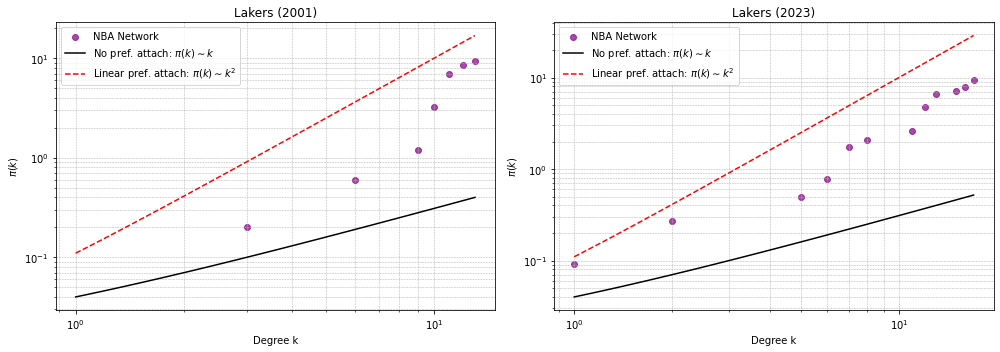

In [ ]:
# Define dataset variations
datasets = {
    "Lakers (2001)": original_df[(original_df['PLAYER1_TEAM_ID'] == 1610612747) & (original_df['Season'] == 2001)],
    "Lakers (2023)": original_df[(original_df['PLAYER1_TEAM_ID'] == 1610612747) & (original_df['Season'] == 2023)],
}

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes = axes.flatten()

for idx, (title, tmp_df) in enumerate(datasets.items()):
    G = nx.DiGraph()

    # Add weighted edges (Passer -> Scorer)
    for _, row in tmp_df.iterrows():
        passer = row["PLAYER2_ID"]
        scorer = row["PLAYER1_ID"]

        if passer == 0 or scorer == 0:
            continue

        if G.has_edge(passer, scorer):
            G[passer][scorer]["weight"] += 1
        else:
            G.add_edge(passer, scorer, weight=1)

    # Compute for NBA Network
    k_nba, Pi_nba = compute_preferential_attachment(G)

    # Define k range for reference lines
    k_range = np.logspace(np.log10(max(1, min(k_nba))), np.log10(max(k_nba)), 100)

    # Define constants for reference lines
    A = 0.01
    c1 = 0.03
    c2 = 0.1

    # Plot Preferential Attachment Function Π(k)
    ax = axes[idx]
    ax.scatter(k_nba, Pi_nba, color="purple", alpha=0.7, label="NBA Network")
    ax.plot(k_range, A + c1 * k_range, 'k-', label=r"No pref. attach: $\pi(k) \sim k$")
    ax.plot(k_range, A + c2 * k_range**2, 'r--', label=r"Linear pref. attach: $\pi(k) \sim k^2$")

    # Log-Log Scale
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Degree k")
    ax.set_ylabel(r"$\pi(k)$")
    ax.set_title(f"{title}")
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()


## Historical Trends

In [4]:
# Extract unique seasons and remove future/incomplete seasons
seasons = sorted(original_df['Season'].unique())
if 2024 in seasons:
    seasons.remove(2024)

# Initialize storage for metrics
metrics = {
    "Season": [], "Num_Edges": [], "Avg_In_Degree": [], "Avg_Out_Degree": [],
    "Global_Clustering": [], "Std_Num_Edges": [], "Std_In_Degree": [], "Std_Out_Degree": [],
    "Std_Global_Clustering": [], "Eigenvector_Centrality": [], "Eigenvector_Centrality_Reversed": [], 
    "Std_Eigenvector_Centrality": [], "Std_Eigenvector_Centrality_Reversed": [], "Out_In_Assortativity": [], "Std_Out_In_Assortativity": []
}

# Loop through each season
for season in seasons:
    season_df = original_df[original_df['Season'] == season]

    # Initialize per-season storage
    num_edges = []
    in_degree_values = []
    out_degree_values = []
    global_clustering_values = []
    eigenvector_centralities = []
    out_in_assortativity_values = []
    eigenvector_centralities_reversed=[]

    # Loop through each team
    for team_id in nba_team_ids:
        team_df = season_df[season_df['PLAYER1_TEAM_ID'] == team_id]

        # Create directed graph (assister → scorer)
        G = nx.DiGraph()
        for _, row in team_df.iterrows():
            passer, scorer = row["PLAYER2_ID"], row["PLAYER1_ID"]
            if passer == 0:
                continue

            if G.has_edge(passer, scorer):
                G[passer][scorer]["weight"] += 1
            else:
                G.add_edge(passer, scorer, weight=1)

        # Compute mean and std for edge weights
        weights = np.array([data["weight"] for _, _, data in G.edges(data=True)])

        if len(weights) > 0:
            min_w, max_w = np.min(weights), np.max(weights)
            for u, v, data in G.edges(data=True):
                data["weight"] = (data["weight"] - min_w) / (max_w - min_w + 1e-9)  # Normalize between 0 and 1

        # Compute team-level stats if graph is not empty
        if G.number_of_nodes() > 0:

            num_edges.append(G.number_of_edges())
            in_degree_values.append(np.mean(list(dict(G.in_degree()).values())))
            out_degree_values.append(np.mean(list(dict(G.out_degree()).values())))

            if G.number_of_edges() > 0 and G.number_of_nodes() > 1:
                try:
                    out_in_assortativity = nx.degree_assortativity_coefficient(G, x='out', y='in')
                    
                except:
                    in_in_assortativity, out_out_assortativity, out_in_assortativity = 0, 0, 0
            else:
                in_in_assortativity, out_out_assortativity, out_in_assortativity = 0, 0, 0

            out_in_assortativity_values.append(out_in_assortativity)

            global_clustering_values.append(nx.transitivity(G))

            eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight="weight")
            eigenvector_centrality_reversed = nx.eigenvector_centrality_numpy(G.reverse(), weight="weight")

            eigenvector_centralities.append(np.mean(list(eigenvector_centrality.values())))
            eigenvector_centralities_reversed.append(np.mean(list(eigenvector_centrality_reversed.values())))

    metrics["Out_In_Assortativity"].append(np.nanmean(out_in_assortativity_values))
    metrics["Std_Out_In_Assortativity"].append(np.nanstd(out_in_assortativity_values))

    metrics["Season"].append(season)
    metrics["Num_Edges"].append(np.mean(num_edges) if num_edges else 0)
    metrics["Avg_In_Degree"].append(np.mean(in_degree_values) if in_degree_values else 0)
    metrics["Avg_Out_Degree"].append(np.mean(out_degree_values) if out_degree_values else 0)
    metrics["Global_Clustering"].append(np.nanmean(global_clustering_values) if global_clustering_values else 0)

    metrics["Std_Num_Edges"].append(np.std(num_edges) if num_edges else 0)
    metrics["Std_In_Degree"].append(np.std(in_degree_values) if in_degree_values else 0)
    metrics["Std_Out_Degree"].append(np.std(out_degree_values) if out_degree_values else 0)
    
    metrics["Std_Global_Clustering"].append(np.std(global_clustering_values) if global_clustering_values else 0)

    metrics["Eigenvector_Centrality"].append(np.mean(eigenvector_centralities) if eigenvector_centralities else 0)
    metrics["Eigenvector_Centrality_Reversed"].append(np.mean(eigenvector_centralities_reversed) if eigenvector_centralities_reversed else 0)
    metrics["Std_Eigenvector_Centrality"].append(np.std(eigenvector_centralities) if eigenvector_centralities else 0)
    metrics["Std_Eigenvector_Centrality_Reversed"].append(np.std(eigenvector_centralities_reversed) if eigenvector_centralities_reversed else 0)


# Convert metrics to DataFrame
df_metrics = pd.DataFrame(metrics)

/Users/sanggyuan/miniconda3/envs/nba_graph/lib/python3.8/site-packages/networkx/algorithms/assortativity/mixing.py:208: RuntimeWarning: invalid value encountered in true_divide
  a = a / a.sum()
/Users/sanggyuan/miniconda3/envs/nba_graph/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/Users/sanggyuan/miniconda3/envs/nba_graph/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: divide by zero encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/Users/sanggyuan/miniconda3/envs/nba_graph/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


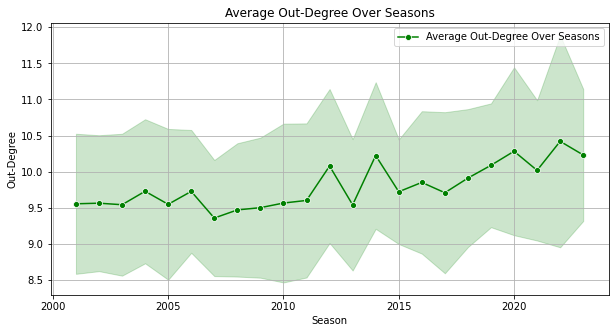

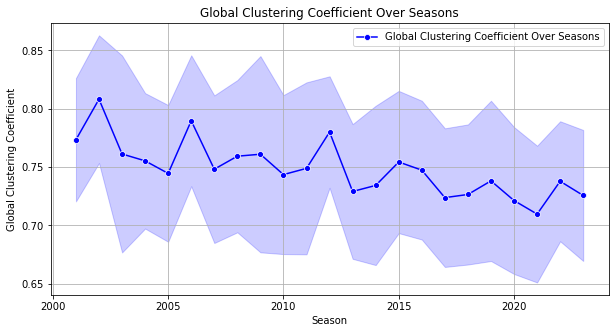

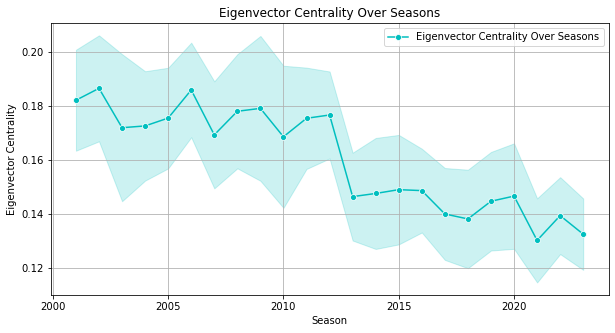

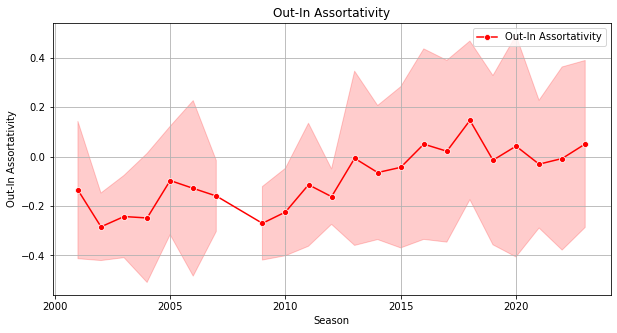

In [5]:
# Define a list of metrics to plot
metrics_to_plot = [
    ("Avg_Out_Degree", "Std_Out_Degree", "Average Out-Degree Over Seasons", "Out-Degree", "g"),
    ("Global_Clustering", "Std_Global_Clustering", "Global Clustering Coefficient Over Seasons", "Global Clustering Coefficient", "b"),
    ("Eigenvector_Centrality", "Std_Eigenvector_Centrality", "Eigenvector Centrality Over Seasons", "Eigenvector Centrality", "c"),    
    ("Out_In_Assortativity", "Std_Out_In_Assortativity", "Out-In Assortativity", "Out-In Assortativity", "r"),
]

# Function to plot a given metric with its standard deviation
def plot_metric(metric, std_metric, title, ylabel, color):
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_metrics, x="Season", y=metric, marker="o", color=color, label=title)
    plt.fill_between(df_metrics["Season"], 
                     df_metrics[metric] - df_metrics[std_metric], 
                     df_metrics[metric] + df_metrics[std_metric], 
                     color=color, alpha=0.2)
    plt.title(title)
    plt.xlabel("Season")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot all selected metrics
for metric, std_metric, title, ylabel, color in metrics_to_plot:
    plot_metric(metric, std_metric, title, ylabel, color)


In [6]:
import pandas as pd
import networkx as nx
import numpy as np

# Load NBA standings
standings_file = "nba_standings.csv"
standings_df = pd.read_csv(standings_file)

def compute_centrality_stats(centrality_dict):
    values = list(centrality_dict.values())
    if len(values) == 0:
        return 0, 0, 0, 0  # Return default values for min, mean, median, std

    return (
        np.min(values),
        np.mean(values),
        np.median(values),
        np.std(values)
    )

# Dictionary to store results
all_results = []

# Loop through each season
for season in standings_df["Season"].unique():
    season_standings = standings_df[standings_df["Season"] == season]

    # Process each team separately
    for _, team_row in season_standings.iterrows():
        team_id = team_row["TeamID"]
        team_name = team_row["Team"]
        team_rank = team_row['Rank']
        conference = team_row["Conference"]

        # Filter interactions for the specific team and season
        df_filtered = original_df[(original_df['Season'] == int(season)) & (original_df['PLAYER1_TEAM_ID'] == team_id)]

        # Create directed graph
        G = nx.DiGraph()
        for _, row in df_filtered.iterrows():
            passer = row["PLAYER2_ID"]
            scorer = row["PLAYER1_ID"]
            if passer == 0:
                continue
            if G.has_edge(passer, scorer):
                G[passer][scorer]["weight"] += 1
            else:
                G.add_edge(passer, scorer, weight=1)


        # Compute Degree Distribution
        out_degrees = np.array(list(dict(G.out_degree()).values()))
        k_avg_out = np.mean(out_degrees) if len(out_degrees) > 0 else 0

        # Compute expected max degree
        k_std_out = np.std(out_degrees) if len(out_degrees) > 0 else 0

        # Compute clustering coefficient
        global_C_nba = nx.transitivity(G)

        # Compute degree assortativity
        assortativity = nx.degree_assortativity_coefficient(G, x='out', y='in')

        # ------------------------ Centrality Measures ------------------------
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight="weight")
        eigenvector_stats = compute_centrality_stats(eigenvector_centrality)

        # Store computed statistics
        team_stats = {
            "Season": season,
            "Team_ID": team_id,
            "Team_Name": team_name,
            "Team_Rank": team_rank,
            "Conference": conference,
            "Avg_Out_Degree": k_avg_out,
            "Degree_Assortativity": assortativity,
            "Global_Clustering_NBA": global_C_nba,
            "Mean_Eigenvector": eigenvector_stats[1],
        }

        all_results.append(team_stats)

# Convert to DataFrame
df_team_results = pd.DataFrame(all_results)

# Save to CSV
df_team_results.to_csv("nba_team_network_stats.csv", index=False)

print("Team statistics stored successfully!")

/Users/sanggyuan/miniconda3/envs/nba_graph/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
/Users/sanggyuan/miniconda3/envs/nba_graph/lib/python3.8/site-packages/networkx/algorithms/assortativity/mixing.py:208: RuntimeWarning: invalid value encountered in true_divide
  a = a / a.sum()
/Users/sanggyuan/miniconda3/envs/nba_graph/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: divide by zero encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


Team statistics stored successfully!


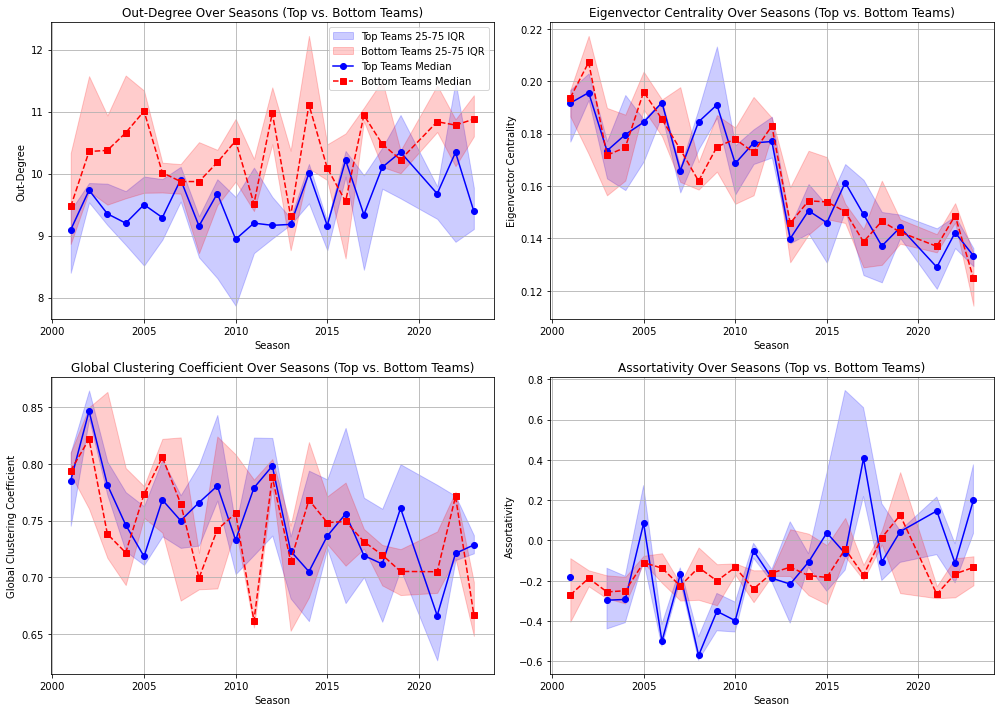

In [7]:
# Load the dataset
file_path = "nba_team_network_stats.csv"
nba_team_network_stats_df = pd.read_csv(file_path)

# Convert Season and Rank to integer for sorting
nba_team_network_stats_df["Season"] = nba_team_network_stats_df["Season"].astype(int)
nba_team_network_stats_df["Team_Rank"] = nba_team_network_stats_df["Team_Rank"].astype(int)

metrics = nba_team_network_stats_df.columns[5:]

# Select first-ranked teams and last-ranked teams
first_teams = nba_team_network_stats_df[nba_team_network_stats_df["Team_Rank"].isin([1,2,3])]  # Top-ranked teams in each conference
last_teams = nba_team_network_stats_df[nba_team_network_stats_df["Team_Rank"].isin([13,14,15])]

# Aggregate metrics by season
# Define aggregation functions to include IQR (25%, 50%, 75%)
agg_funcs = ["mean", "std", "min", "max", lambda x: x.quantile(0.25), "median", lambda x: x.quantile(0.75)]

# Compute aggregated statistics for top and bottom teams
first_agg = first_teams.groupby("Season")[metrics].agg(agg_funcs)
last_agg = last_teams.groupby("Season")[metrics].agg(agg_funcs)

# Ensure column names remain structured correctly
first_agg.columns = pd.MultiIndex.from_tuples([
    (metric, 
     "25%" if func == "<lambda_0>" else 
     "50%" if func == "median" else 
     "75%" if func == "<lambda_1>" else func) 
    for metric, func in first_agg.columns
])

last_agg.columns = first_agg.columns  # Ensure consistent column names

# Define the metrics for the 2x2 subplot layout
metrics_to_plot = [
    ("Avg_Out_Degree", "Out-Degree"), 
    ("Mean_Eigenvector", "Eigenvector Centrality"), 
    ("Global_Clustering_NBA", "Global Clustering Coefficient"), 
    ("Degree_Assortativity", "Assortativity")
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid

for i, (ax, (metric, title)) in enumerate(zip(axes.flatten(), metrics_to_plot)):

    # Shaded area for 25th-75th percentile range (IQR)
    ax.fill_between(first_agg.index, 
                    first_agg[metric]["25%"], 
                    first_agg[metric]["75%"],  
                    alpha=0.2, label="Top Teams 25-75 IQR", color="blue")
    
    ax.fill_between(last_agg.index, 
                    last_agg[metric]["25%"], 
                    last_agg[metric]["75%"], 
                    alpha=0.2, label="Bottom Teams 25-75 IQR", color="red")

    # Median line
    ax.plot(first_agg.index, first_agg[metric]["50%"], marker="o", linestyle="-", label="Top Teams Median", color="blue")
    ax.plot(last_agg.index, last_agg[metric]["50%"], marker="s", linestyle="--", label="Bottom Teams Median", color="red")

    ax.set_xlabel("Season")
    ax.set_ylabel(title)
    ax.set_title(f"{title} Over Seasons (Top vs. Bottom Teams)")
    ax.grid(True)

    # Only show legend in the first subplot
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()


## Resilience test

In [8]:
# import pandas as pd
# import networkx as nx
# import numpy as np
# import random

# # Load NBA standings
# standings_file = "nba_standings.csv"
# standings_df = pd.read_csv(standings_file)

# # Load player interaction dataset
# file_path = "data/nba_player_interactions_2001_2025.csv"
# df = pd.read_csv(file_path)

# def compute_percentage_change(initial, post):
#     if initial == 0:  # Avoid division by zero
#         return 0
#     return ((post - initial) / initial) * 100

# # Define NBA teams (mapping TeamID to Name)
# nba_team_map = {
#     1610612737: "Atlanta Hawks", 1610612738: "Boston Celtics",
#     1610612751: "Brooklyn Nets", 1610612766: "Charlotte Hornets",
#     1610612741: "Chicago Bulls", 1610612739: "Cleveland Cavaliers",
#     1610612742: "Dallas Mavericks", 1610612743: "Denver Nuggets",
#     1610612765: "Detroit Pistons", 1610612744: "Golden State Warriors",
#     1610612745: "Houston Rockets", 1610612754: "Indiana Pacers",
#     1610612746: "Los Angeles Clippers", 1610612747: "Los Angeles Lakers",
#     1610612763: "Memphis Grizzlies", 1610612748: "Miami Heat",
#     1610612749: "Milwaukee Bucks", 1610612750: "Minnesota Timberwolves",
#     1610612740: "New Orleans Pelicans", 1610612752: "New York Knicks",
#     1610612760: "Oklahoma City Thunder", 1610612753: "Orlando Magic",
#     1610612755: "Philadelphia 76ers", 1610612756: "Phoenix Suns",
#     1610612757: "Portland Trail Blazers", 1610612758: "Sacramento Kings",
#     1610612759: "San Antonio Spurs", 1610612761: "Toronto Raptors",
#     1610612762: "Utah Jazz", 1610612764: "Washington Wizards"
# }

# df = df[df['PLAYER1_TEAM_ID'].isin(nba_team_map.keys())]

# # Dictionary to store results
# resilience_results = []

# # Loop through each season
# for season in standings_df["Season"].unique():
#     season_standings = standings_df[standings_df["Season"] == season]

#     # Process each team separately
#     for _, team_row in season_standings.iterrows():
#         team_id = team_row["TeamID"]
#         team_name = team_row["Team"]
#         team_rank = team_row['Rank']
#         conference = team_row["Conference"]

#         if team_rank not in [1,2,3,4,5,11,12,13,14,15]:
#             continue

#         # Filter interactions for the specific team and season
#         df_filtered = df[(df['Season'] == int(season)) & (df['PLAYER1_TEAM_ID'] == team_id)]

#         # Create directed graph
#         G = nx.DiGraph()
#         for _, row in df_filtered.iterrows():
#             passer = row["PLAYER2_ID"]
#             scorer = row["PLAYER1_ID"]
#             if passer == 0:
#                 continue
#             if G.has_edge(passer, scorer):
#                 G[passer][scorer]["weight"] += 1
#             else:
#                 G.add_edge(passer, scorer, weight=1)

#         if G.number_of_nodes() < 5:  # Skip teams with too few players
#             continue

#         # Compute initial network metrics
#         def compute_metrics(graph):
#             metrics = {}
#             metrics["Avg_Out_Degree"] = np.mean(list(dict(graph.out_degree()).values()))
#             metrics["Global_Clustering"] = nx.transitivity(graph)
#             metrics["Assortativity"] = nx.degree_assortativity_coefficient(graph, x='out', y='in')
#             eigenvector_centrality = nx.eigenvector_centrality_numpy(graph, weight="weight")
#             metrics["Eigenvector_Centrality"] = np.mean(list(eigenvector_centrality.values()))
#             return metrics

#         initial_metrics = compute_metrics(G)

#         # Storage for repeated trials
#         out_degree_changes = []
#         global_clustering_changes = []
#         assortativity_changes = []
#         eigenvector_changes = []

#         # Repeat the process 5 times
#         for _ in range(15):
#             G_temp = G.copy()

#             # Identify key player (highest eigenvector centrality)
#             eigenvector_centrality = nx.eigenvector_centrality_numpy(G_temp, weight="weight")
#             key_player = max(eigenvector_centrality, key=eigenvector_centrality.get)

#             # Identify 2 additional random players
#             all_players = list(G_temp.nodes())
#             all_players.remove(key_player)
#             random_players = random.sample(all_players, min(2, len(all_players)))  # Select 2 if possible

#             # Remove the 3 players (1 key + 2 random)
#             G_temp.remove_nodes_from([key_player] + random_players)

#             post_removal_metrics = compute_metrics(G_temp)

#             # Store changes
#             out_degree_changes.append(compute_percentage_change(initial_metrics["Avg_Out_Degree"], post_removal_metrics["Avg_Out_Degree"]))
#             global_clustering_changes.append(compute_percentage_change(initial_metrics["Global_Clustering"], post_removal_metrics["Global_Clustering"]))
#             assortativity_changes.append(compute_percentage_change(initial_metrics["Assortativity"], post_removal_metrics["Assortativity"]))
#             eigenvector_changes.append(compute_percentage_change(initial_metrics["Eigenvector_Centrality"], post_removal_metrics["Eigenvector_Centrality"]))

#         # Store average results across trials
#         team_resilience = {
#             "Season": season,
#             "Team_ID": team_id,
#             "Team_Name": team_name,
#             "Team_Rank": team_rank,
#             "Conference": conference,
#             "Out_Degree_Percentage_Change": np.nanmean(out_degree_changes),
#             "Global_Clustering_Percentage_Change": np.nanmean(global_clustering_changes),
#             "Assortativity_Percentage_Change": np.nanmean(assortativity_changes),
#             "Eigenvector_Percentage_Change": np.nanmean(eigenvector_changes)
#         }

#         resilience_results.append(team_resilience)

# # Convert to DataFrame
# df_resilience = pd.DataFrame(resilience_results)

# # Save to CSV
# df_resilience.to_csv("nba_team_resilience_stats.csv", index=False)

# print("Resilience statistics stored successfully!")


In [9]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Define metrics to analyze
# metrics_to_plot = [
#     ("Out_Degree_Percentage_Change", "Out-Degree Change"),
#     ("Eigenvector_Percentage_Change", "Eigenvector Centrality Change"),
#     ("Global_Clustering_Percentage_Change", "Global Clustering Change"),
#     ("Assortativity_Percentage_Change", "Assortativity Change")
# ]

# # Separate top and bottom teams
# top_teams = df_resilience[df_resilience["Team_Rank"] <= 3]  # Top 5 teams
# bottom_teams = df_resilience[df_resilience["Team_Rank"] >= 13]  # Bottom 5 teams

# # Function to compute IQR (25%, 50%, 75%) manually
# def compute_iqr(df, metric):
#     grouped = df.groupby("Season")[metric].agg([lambda x: x.quantile(0.25), 
#                                                 lambda x: x.median(), 
#                                                 lambda x: x.quantile(0.75)])
#     grouped.columns = ["25%", "50%", "75%"]
#     return grouped

# # Compute IQR for top and bottom teams
# top_agg = {metric: compute_iqr(top_teams, metric) for metric, _ in metrics_to_plot}
# bottom_agg = {metric: compute_iqr(bottom_teams, metric) for metric, _ in metrics_to_plot}

# # Create 2x2 subplots
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# for ax, (metric, title) in zip(axes.flatten(), metrics_to_plot):
#     # Plot shaded IQR range
#     ax.fill_between(top_agg[metric].index, 
#                     top_agg[metric]["25%"], 
#                     top_agg[metric]["75%"], 
#                     alpha=0.2, color="blue", label="Top Teams IQR")
    
#     ax.fill_between(bottom_agg[metric].index, 
#                     bottom_agg[metric]["25%"], 
#                     bottom_agg[metric]["75%"], 
#                     alpha=0.2, color="red", label="Bottom Teams IQR")

#     # Median line
#     ax.plot(top_agg[metric].index, top_agg[metric]["50%"], marker="o", linestyle="-", color="blue", label="Top Teams Median")
#     ax.plot(bottom_agg[metric].index, bottom_agg[metric]["50%"], marker="s", linestyle="--", color="red", label="Bottom Teams Median")

#     ax.set_xlabel("Season")
#     ax.set_ylabel(title)
#     ax.set_title(f"Change in {title} After Key Player Removal")
#     ax.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line for no change
#     ax.grid(True)

# # Show legend in only one subplot
# axes[0, 0].legend()

# plt.tight_layout()
# plt.show()
